In [43]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import tensorflow as tf

import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from matplotlib.ticker import FuncFormatter

from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

## Data Understanding and Preprocessing:

Begin by understanding the structure and content of your dataset. Ensure that you have a clear understanding of each feature and its significance.
Preprocess your data, which may include handling missing values, encoding categorical variables, and scaling numerical features if necessary.

In [33]:
"""
sample_submission = pd.read_csv("/kaggle/input/iyzico-datathon/sample_submission.csv")
base_train = pd.read_csv("/kaggle/input/iyzico-datathon/train.csv")
"""

sample_submission = pd.read_csv("sample_submission.csv")
base_train = pd.read_csv("train.csv")

In [34]:
base_train

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
0,merchant_43992,202307,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,15106
1,merchant_43992,202301,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16918
2,merchant_43992,202305,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,13452
3,merchant_43992,202308,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16787
4,merchant_43992,202302,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,12428
...,...,...,...,...,...,...,...,...
291137,merchant_67083,202309,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_169,Segment - 4,4
291138,merchant_4263,202309,Merchant Source - 2,Settlement Period - 1,Working Type - 6,mcc_73,Segment - 4,4
291139,merchant_11346,202309,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_169,Segment - 4,3
291140,merchant_21397,202309,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_168,Segment - 4,3


In [35]:
base_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291142 entries, 0 to 291141
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   merchant_id           291142 non-null  object
 1   month_id              291142 non-null  int64 
 2   merchant_source_name  291142 non-null  object
 3   settlement_period     291142 non-null  object
 4   working_type          291142 non-null  object
 5   mcc_id                291142 non-null  object
 6   merchant_segment      291142 non-null  object
 7   net_payment_count     291142 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 17.8+ MB


In [36]:
base_train.describe()

,month_id,net_payment_count
count,291142.000000,2.911420e+05
mean,202159.680860,4.153842e+02
std,104.214948,1.082067e+04
min,202001.000000,-1.433000e+03
25%,202103.000000,4.000000e+00
50%,202201.000000,6.000000e+00
75%,202211.000000,1.400000e+01
max,202309.000000,1.160429e+06


In [37]:
print(f"Unique values for merchant id {base_train['merchant_id'].nunique()}")
print(f"Unique values for month id {base_train['month_id'].nunique()}")
print(f"Unique values for merchant_source_name {base_train['merchant_source_name'].nunique()}")
print(f"Unique values for settlement_period {base_train['settlement_period'].nunique()}")
print(f"Unique values for working_type {base_train['working_type'].nunique()}")
print(f"Unique values for mcc_id {base_train['mcc_id'].nunique()}")
print(f"Unique values for merchant_segment {base_train['merchant_segment'].nunique()}")
print(f"Unique values for net_payment_count {base_train['net_payment_count'].nunique()}")

Unique values for merchant id 26060
Unique values for month id 45
Unique values for merchant_source_name 3
Unique values for settlement_period 3
Unique values for working_type 6
Unique values for mcc_id 172
Unique values for merchant_segment 4
Unique values for net_payment_count 5039


In [38]:
for column in base_train.columns:
    print(base_train[column].value_counts())

merchant_id
merchant_43992    45
merchant_19380    45
merchant_1100     45
merchant_17200    45
merchant_65293    45
                  ..
merchant_3063      1
merchant_35756     1
merchant_50399     1
merchant_56272     1
merchant_66895     1
Name: count, Length: 26060, dtype: int64
month_id
202112    7413
202303    7367
202203    7332
202305    7327
202308    7315
202309    7287
202204    7244
202307    7217
202201    7210
202301    7198
202304    7191
202212    7153
202111    7129
202211    7086
202210    7073
202205    7072
202306    7065
202202    7064
202105    7045
202206    7040
202109    7021
202110    7018
202106    7004
202209    6967
202103    6883
202104    6878
202208    6876
202302    6804
202108    6771
202207    6648
202102    6607
202107    6490
202101    6437
202012    6352
202011    5887
202010    5654
202009    5489
202008    5224
202007    4990
202006    4920
202005    4707
202004    4120
202003    3951
202002    3867
202001    3749
Name: count, dtype: int64
mercha

In [39]:
test_data = sample_submission.copy()
test_data

,id,net_payment_count
0,202311merchant_36004,0
1,202312merchant_36004,0
2,202310merchant_36004,0
3,202311merchant_23099,0
4,202312merchant_23099,0
...,...,...
78175,202312merchant_35969,0
78176,202310merchant_35969,0
78177,202311merchant_8429,0
78178,202312merchant_8429,0


In [40]:
test_data[['month_id', 'merchant_id']] = test_data['id'].str.extract(r'(\d{6})(merchant_\d+)')
test_data

,id,net_payment_count,month_id,merchant_id
0,202311merchant_36004,0,202311,merchant_36004
1,202312merchant_36004,0,202312,merchant_36004
2,202310merchant_36004,0,202310,merchant_36004
3,202311merchant_23099,0,202311,merchant_23099
4,202312merchant_23099,0,202312,merchant_23099
...,...,...,...,...
78175,202312merchant_35969,0,202312,merchant_35969
78176,202310merchant_35969,0,202310,merchant_35969
78177,202311merchant_8429,0,202311,merchant_8429
78178,202312merchant_8429,0,202312,merchant_8429


In [41]:
data = base_train.copy() 
data['month_id'] = pd.to_datetime(data['month_id'], format='%Y%m')
test_data['month_id'] = pd.to_datetime(test_data['month_id'], format='%Y%m')
test_data

,id,net_payment_count,month_id,merchant_id
0,202311merchant_36004,0,2023-11-01,merchant_36004
1,202312merchant_36004,0,2023-12-01,merchant_36004
2,202310merchant_36004,0,2023-10-01,merchant_36004
3,202311merchant_23099,0,2023-11-01,merchant_23099
4,202312merchant_23099,0,2023-12-01,merchant_23099
...,...,...,...,...
78175,202312merchant_35969,0,2023-12-01,merchant_35969
78176,202310merchant_35969,0,2023-10-01,merchant_35969
78177,202311merchant_8429,0,2023-11-01,merchant_8429
78178,202312merchant_8429,0,2023-12-01,merchant_8429


In [42]:
cluster_data = data.copy() # Remove unnecessary columns
cluster_data = pd.get_dummies(cluster_data, columns= ["working_type", "merchant_segment", "merchant_source_name", "settlement_period"])  # One-hot encode categorical variables if necessary
cluster_data

,merchant_id,month_id,mcc_id,net_payment_count,working_type_Working Type - 1,working_type_Working Type - 2,working_type_Working Type - 3,working_type_Working Type - 4,working_type_Working Type - 5,working_type_Working Type - 6,merchant_segment_Segment - 1,merchant_segment_Segment - 2,merchant_segment_Segment - 3,merchant_segment_Segment - 4,merchant_source_name_Merchant Source - 1,merchant_source_name_Merchant Source - 2,merchant_source_name_Merchant Source - 3,settlement_period_Settlement Period - 1,settlement_period_Settlement Period - 2,settlement_period_Settlement Period - 3
0,merchant_43992,2023-07-01,mcc_197,15106,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True
1,merchant_43992,2023-01-01,mcc_197,16918,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True
2,merchant_43992,2023-05-01,mcc_197,13452,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True
3,merchant_43992,2023-08-01,mcc_197,16787,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True
4,merchant_43992,2023-02-01,mcc_197,12428,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291137,merchant_67083,2023-09-01,mcc_169,4,False,False,False,False,False,True,False,False,False,True,True,False,False,True,False,False
291138,merchant_4263,2023-09-01,mcc_73,4,False,False,False,False,False,True,False,False,False,True,False,True,False,True,False,False
291139,merchant_11346,2023-09-01,mcc_169,3,False,False,False,False,False,True,False,False,False,True,True,False,False,True,False,False
291140,merchant_21397,2023-09-01,mcc_168,3,False,False,False,False,False,True,False,False,False,True,True,False,False,True,False,False


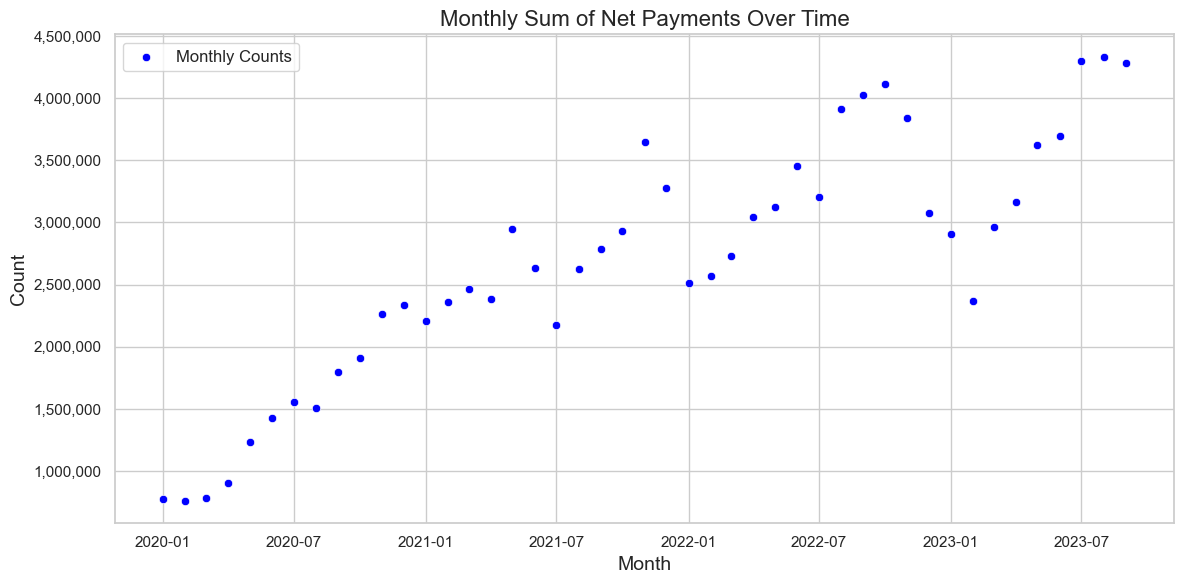

In [19]:
# Group by month_id and sum the net_payment_count for each month
monthly_counts = data.groupby('month_id')['net_payment_count'].sum()

# Set up a seaborn style for better aesthetics
sns.set(style="whitegrid", palette="husl")

# Define a function to format y-axis ticks
def format_ticks(value, _):
    return f'{int(value):,}'

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(data=monthly_counts.reset_index(), x='month_id', y='net_payment_count', color='blue', label='Monthly Counts')

# Apply the formatting function to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))


plt.title('Monthly Sum of Net Payments Over Time', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()


In [11]:
monthly_counts

month_id
2020-01-01     775289
2020-02-01     759571
2020-03-01     784726
2020-04-01     906968
2020-05-01    1234374
2020-06-01    1424606
2020-07-01    1559296
2020-08-01    1508304
2020-09-01    1801105
2020-10-01    1907334
2020-11-01    2263692
2020-12-01    2335235
2021-01-01    2204802
2021-02-01    2358530
2021-03-01    2464850
2021-04-01    2388236
2021-05-01    2948518
2021-06-01    2636933
2021-07-01    2172452
2021-08-01    2625566
2021-09-01    2787039
2021-10-01    2934176
2021-11-01    3646847
2021-12-01    3275615
2022-01-01    2509716
2022-02-01    2568446
2022-03-01    2730111
2022-04-01    3042259
2022-05-01    3122160
2022-06-01    3453755
2022-07-01    3203420
2022-08-01    3909944
2022-09-01    4021619
2022-10-01    4111855
2022-11-01    3842774
2022-12-01    3075363
2023-01-01    2910984
2023-02-01    2368511
2023-03-01    2967131
2023-04-01    3161692
2023-05-01    3619637
2023-06-01    3694900
2023-07-01    4301209
2023-08-01    4333899
2023-09-01    4282338
N

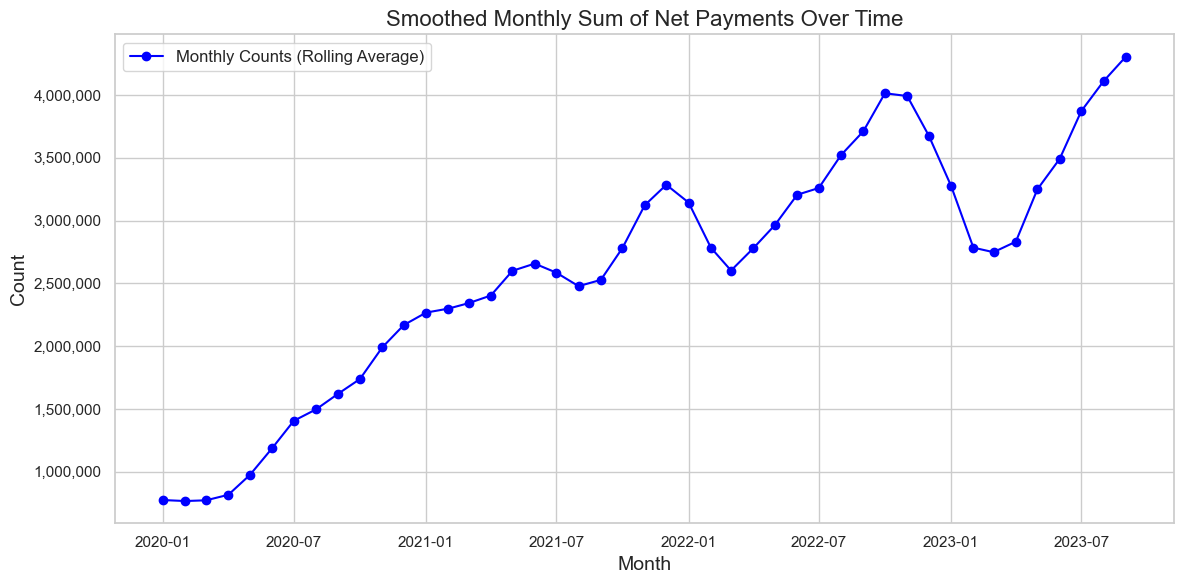

In [20]:
# Smooth out fluctuations using a rolling average
rolling_avg = monthly_counts.rolling(window=3, min_periods=1).mean()

# Set up a seaborn style for better aesthetics
sns.set(style="whitegrid", palette="husl")

# Define a function to format y-axis ticks
def format_ticks(value, _):
    return f'{int(value):,}'

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(rolling_avg.index, rolling_avg.values, color='blue', marker='o', label='Monthly Counts (Rolling Average)')

# Apply the formatting function to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.title('Smoothed Monthly Sum of Net Payments Over Time', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()


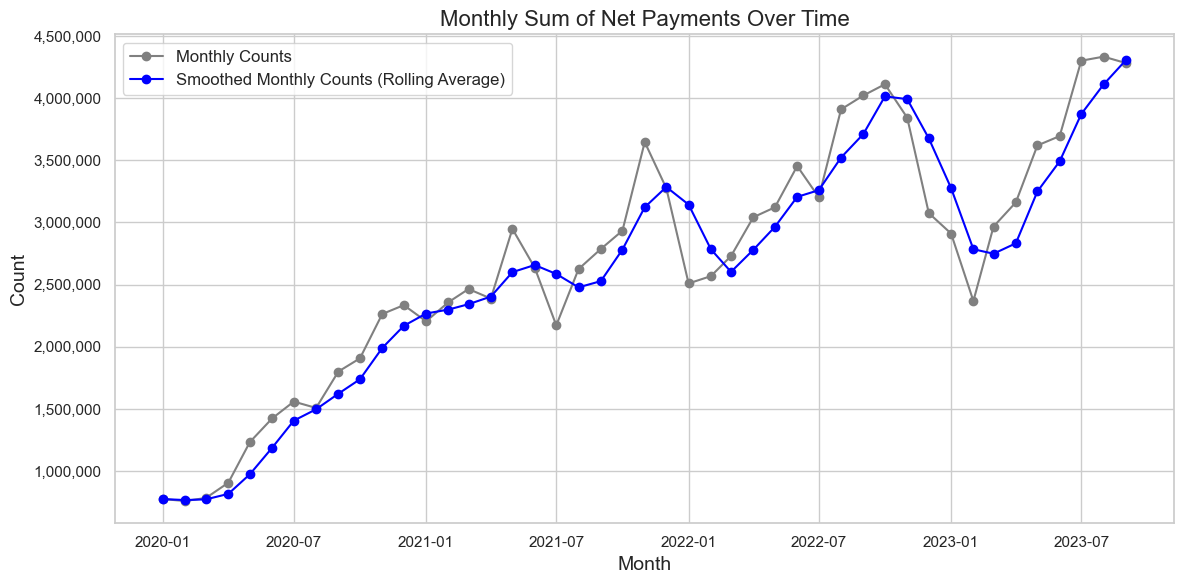

In [21]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot raw monthly counts
plt.plot(monthly_counts.index, monthly_counts.values, color='gray', marker='o', label='Monthly Counts')

# Plot smoothed monthly counts (rolling average)
plt.plot(rolling_avg.index, rolling_avg.values, color='blue', marker='o', label='Smoothed Monthly Counts (Rolling Average)')

# Apply the formatting function to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.title('Monthly Sum of Net Payments Over Time', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()


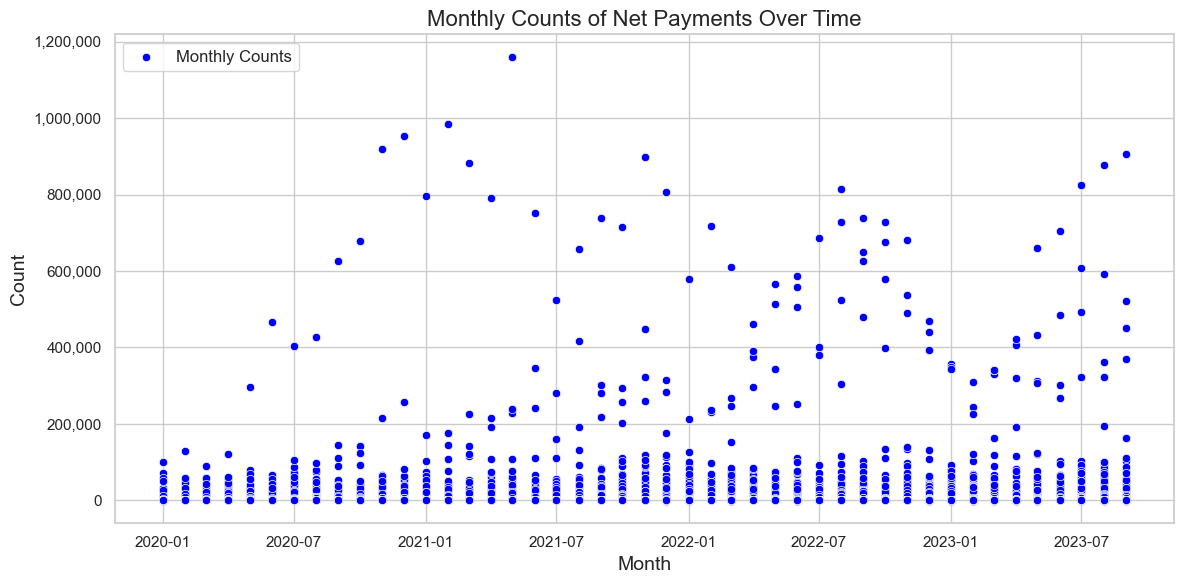

In [55]:
# Assuming data is already loaded and processed as described in your code
data.set_index('month_id', inplace=True)

# Set up a seaborn style for better aesthetics
sns.set(style="whitegrid", palette="husl")

# Define a function to format y-axis ticks
def format_ticks(value, _):
    return f'{int(value):,}'

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(data=data, x=data.index, y='net_payment_count', color='blue', label='Monthly Counts')

# Apply the formatting function to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.title('Monthly Counts of Net Payments Over Time', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()


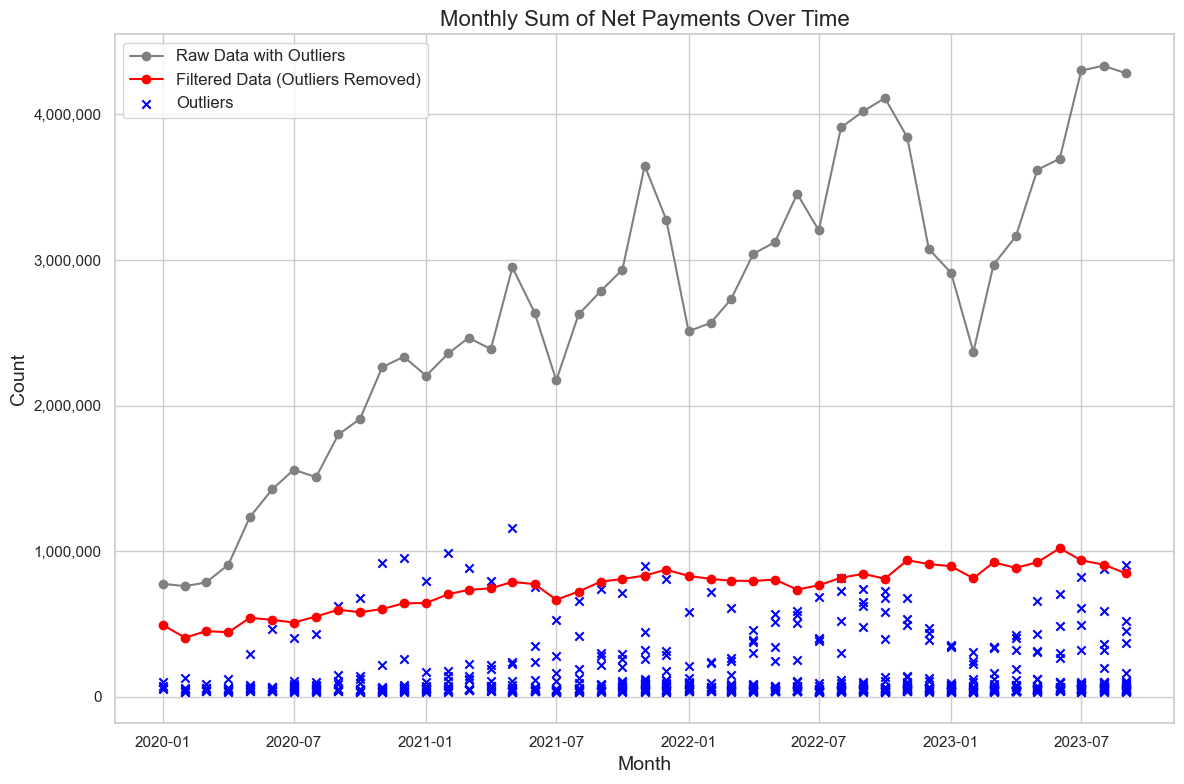

               merchant_id merchant_source_name      settlement_period  \
month_id                                                                 
2022-08-01  merchant_60635  Merchant Source - 3  Settlement Period - 3   
2022-10-01  merchant_60635  Merchant Source - 3  Settlement Period - 3   
2022-09-01  merchant_60635  Merchant Source - 3  Settlement Period - 3   
2022-11-01  merchant_60635  Merchant Source - 3  Settlement Period - 3   
2022-07-01  merchant_60635  Merchant Source - 3  Settlement Period - 3   
...                    ...                  ...                    ...   
2023-09-01  merchant_28397  Merchant Source - 1  Settlement Period - 2   
2023-06-01  merchant_28397  Merchant Source - 1  Settlement Period - 2   
2023-07-01  merchant_28397  Merchant Source - 1  Settlement Period - 2   
2023-08-01  merchant_28397  Merchant Source - 1  Settlement Period - 2   
2023-04-01  merchant_28397  Merchant Source - 1  Settlement Period - 2   

                working_type  mcc_id 

In [57]:
# Calculate z-scores for each net_payment_count value
z_scores = (data['net_payment_count'] - data['net_payment_count'].mean()) / data['net_payment_count'].std()

# Define a threshold for outlier detection
threshold = 3

# Filter out data points with z-scores greater than the threshold (outliers)
outliers = data[abs(z_scores) >= threshold]

# Filter out data points with z-scores less than the threshold (non-outliers)
filtered_data = data[abs(z_scores) < threshold]

# Group by month_id and sum the net_payment_count for each month for both original and filtered data
monthly_counts = data.groupby('month_id')['net_payment_count'].sum()
filtered_monthly_counts = filtered_data.groupby('month_id')['net_payment_count'].sum()

# Set up a seaborn style for better aesthetics
sns.set(style="whitegrid", palette="husl")

# Define a function to format y-axis ticks
def format_ticks(value, _):
    return f'{int(value):,}'

# Plotting
plt.figure(figsize=(12, 8))

# Plot raw monthly counts with outliers
plt.plot(monthly_counts.index, monthly_counts.values, color='gray', marker='o', linestyle='-', label='Raw Data with Outliers')

# Plot filtered monthly counts without outliers
plt.plot(filtered_monthly_counts.index, filtered_monthly_counts.values, color='red', marker='o', linestyle='-', label='Filtered Data (Outliers Removed)')

# Plot outliers
plt.scatter(outliers.index, outliers['net_payment_count'], color='blue', marker='x', label='Outliers')

# Apply the formatting function to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.title('Monthly Sum of Net Payments Over Time', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()


print(outliers)

In [60]:
filtered_monthly_counts

month_id
2020-01-01     492688
2020-02-01     405168
2020-03-01     450770
2020-04-01     442833
2020-05-01     542148
2020-06-01     527956
2020-07-01     509598
2020-08-01     550956
2020-09-01     597776
2020-10-01     580397
2020-11-01     602543
2020-12-01     641520
2021-01-01     643672
2021-02-01     704566
2021-03-01     733865
2021-04-01     744509
2021-05-01     788636
2021-06-01     773155
2021-07-01     665935
2021-08-01     722447
2021-09-01     790539
2021-10-01     808594
2021-11-01     832466
2021-12-01     872492
2022-01-01     829663
2022-02-01     809121
2022-03-01     796954
2022-04-01     795284
2022-05-01     804361
2022-06-01     735903
2022-07-01     765352
2022-08-01     817059
2022-09-01     844192
2022-10-01     810168
2022-11-01     937601
2022-12-01     911592
2023-01-01     895599
2023-02-01     813539
2023-03-01     922567
2023-04-01     885303
2023-05-01     923227
2023-06-01    1019787
2023-07-01     936703
2023-08-01     907770
2023-09-01     847344
N

In [61]:
monthly_counts

month_id
2020-01-01     775289
2020-02-01     759571
2020-03-01     784726
2020-04-01     906968
2020-05-01    1234374
2020-06-01    1424606
2020-07-01    1559296
2020-08-01    1508304
2020-09-01    1801105
2020-10-01    1907334
2020-11-01    2263692
2020-12-01    2335235
2021-01-01    2204802
2021-02-01    2358530
2021-03-01    2464850
2021-04-01    2388236
2021-05-01    2948518
2021-06-01    2636933
2021-07-01    2172452
2021-08-01    2625566
2021-09-01    2787039
2021-10-01    2934176
2021-11-01    3646847
2021-12-01    3275615
2022-01-01    2509716
2022-02-01    2568446
2022-03-01    2730111
2022-04-01    3042259
2022-05-01    3122160
2022-06-01    3453755
2022-07-01    3203420
2022-08-01    3909944
2022-09-01    4021619
2022-10-01    4111855
2022-11-01    3842774
2022-12-01    3075363
2023-01-01    2910984
2023-02-01    2368511
2023-03-01    2967131
2023-04-01    3161692
2023-05-01    3619637
2023-06-01    3694900
2023-07-01    4301209
2023-08-01    4333899
2023-09-01    4282338
N

## Exploratory Data Analysis (EDA):

Conduct EDA to gain insights into the distribution of your features, identify patterns, correlations, and outliers.
Visualize the time series data to understand its trend, seasonality, and any other patterns that might be present.


## Time Series Forecasting with ARIMA:

Split your dataset into training and test sets. Since you have monthly data, you may want to reserve the last few months for testing.
Implement an ARIMA model to forecast the net_payment_count for the test period. Tune the hyperparameters of the ARIMA model to achieve the best performance.
Evaluate the ARIMA model's performance using appropriate metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), etc.

## Feature Engineering:

Utilize the additional columns (merchant_source, settlement_period, working_type, mcc_id, merchant_segment) to engineer new features that could potentially improve your model's performance.
Consider creating lag features, rolling window statistics, or any other relevant transformations based on domain knowledge or insights gained from EDA.

## Model Building:

Incorporate the engineered features into your dataset and split it into training and test sets.
Choose an appropriate machine learning model (e.g., RandomForest, Gradient Boosting, Neural Networks) to train on the dataset.
Perform hyperparameter tuning using techniques like grid search or random search to optimize the model's performance.
Evaluate the model using appropriate evaluation metrics and compare it with the ARIMA model's performance.

## Model Evaluation and Selection:

Compare the performance of the ARIMA model and the machine learning model based on evaluation metrics such as MAE, MSE, etc.
Select the model that provides the best performance on the test set.

## Model Deployment and Monitoring:

Once you have selected the final model, deploy it into your production environment.
Monitor the model's performance over time and retrain it periodically with new data if necessary.
Continuously evaluate and iterate on your model to maintain its effectiveness.

## Documentation and Reporting:

Document all the steps taken in your project, including data preprocessing, model building, evaluation results, and any insights gained.
Prepare a report summarizing your findings, methodology, and recommendations for stakeholders.